In [1]:
import pandas as pd
import os
import requests
import io
import matplotlib.pyplot as plt
import numpy as np
import nltk
nltk.download('punkt')


import operator

import re
import seaborn as sns

from wordcloud import WordCloud


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
path ='https://raw.githubusercontent.com/iAnkitar/ISR_Spotlight/master/train.csv'
r = requests.get(path)
train_df = pd.read_csv(io.StringIO(r.text))

train_df.sample(5)

,stance,message,tweetid
4974,2,RT @insideclimate: Gov. Jerry Brown warns Trum...,665275
3367,0,@RailaOdinga @RailaOdinga thanks for showing u...,919034
252,-1,I was thinking the same thing. Same goes with ...,301923
551,1,@maryedavis72 I’m creating a new think tank fo...,785415
1083,2,Trump takes aim at Obama’s efforts to curb cli...,655645


In [4]:
df_filtered = train_df[train_df['stance'] <= 1]
df_filtered['stance'].value_counts()

 1    8530
 0    2353
-1    1296
Name: stance, dtype: int64

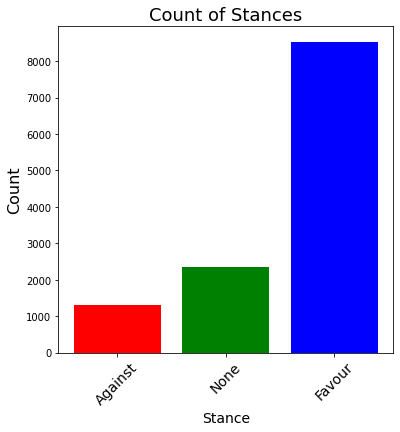

In [5]:
# Plot a distribution of the dataset
plt.figure(figsize=(6,6))
Index = [1,0,-1]
Mood_count = df_filtered['stance'].value_counts()

plt.bar(Index, Mood_count, color=['blue','green', 'red'])
plt.xticks(Index,['Favour','None','Against'],rotation=45, fontsize=14)
plt.ylabel('Count', fontsize=16)
plt.xlabel('Stance', fontsize=14)
plt.title('Count of Stances', fontsize=18)
#plt.annotate(text = Mood_count[0], xy = (0.13,22000), size = 18,s=None)

plt.savefig('sentiments_count.png')

count    15819.000000
mean        17.685062
std          4.443909
min          2.000000
25%         15.000000
50%         18.000000
75%         21.000000
max         31.000000
dtype: float64


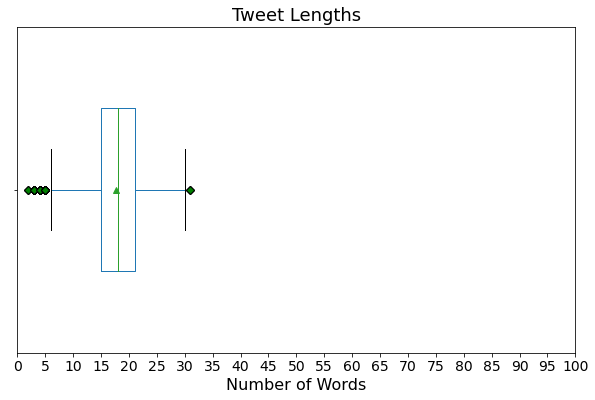

In [6]:
# Calculate tweet lengths
plt.figure(figsize=(10,6))
tweet_len = pd.Series([len(tweet.split()) for tweet in train_df['message']])
print(tweet_len.describe())

# The distribution of tweet text lengths
green_diamond = dict(markerfacecolor='g', marker='D')
tweet_len.plot(kind='box', vert=False, widths=0.5, 
               showmeans=True,
               flierprops=green_diamond)
plt.xlabel('Number of Words', fontsize=16)
plt.xticks(np.arange(0, 101, 5), fontsize=14)
plt.yticks([1], " ")
plt.title("Tweet Lengths", fontsize=18)
plt.show()

In [7]:
df_new = train_df.copy()
df_new['length'] = train_df['message'].str.split().apply(len)
df_new.head()

,stance,message,tweetid,length
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,19
1,1,It's not like we lack evidence of anthropogeni...,126103,10
2,2,RT @RawStory: Researchers say we have three ye...,698562,19
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,15
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,18


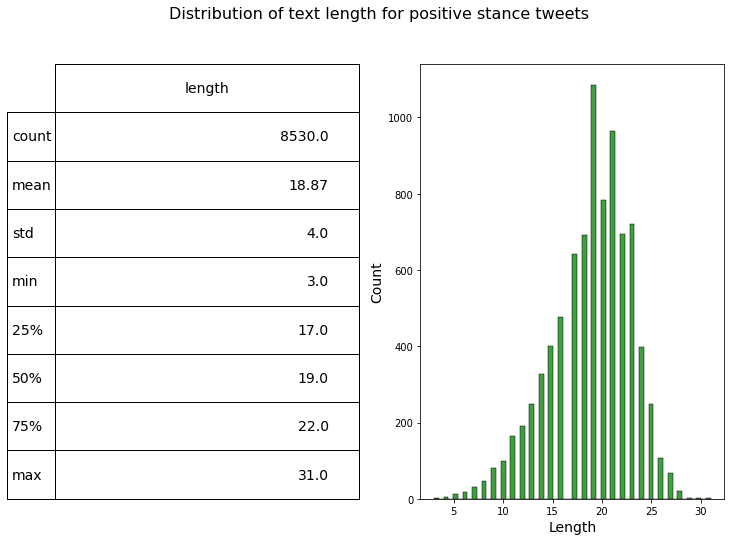

In [8]:
# Plotting the distribution of text length for Favor stance tweets
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(122)
hist = sns.histplot(df_new[df_new['stance']==1]['length'], ax=ax1,color='green')
hist.set_xlabel("Length", fontsize = 14)
hist.set_ylabel("Count", fontsize = 14)
describe = df_new.length[df_new['stance']==1].describe().to_frame().round(2)
ax1.font_size=14

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive stance tweets', fontsize=16)

plt.show()

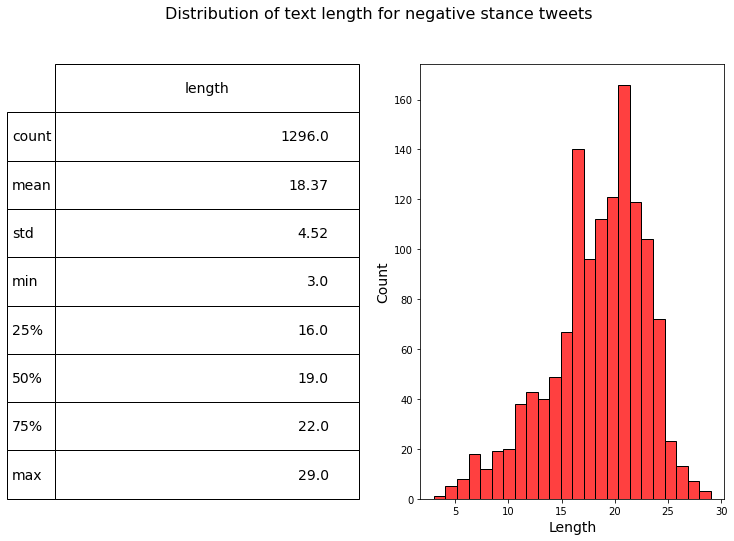

In [9]:
# Plotting the distribution of text length for Against tweets
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(122)
hist = sns.histplot(df_new[df_new['stance']==-1]['length'], ax=ax1,color='red')
hist.set_xlabel("Length", fontsize = 14)
hist.set_ylabel("Count", fontsize = 14)
describe = df_new.length[df_new['stance']==-1].describe().to_frame().round(2)
ax1.font_size=14

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for negative stance tweets', fontsize=16)

plt.show()

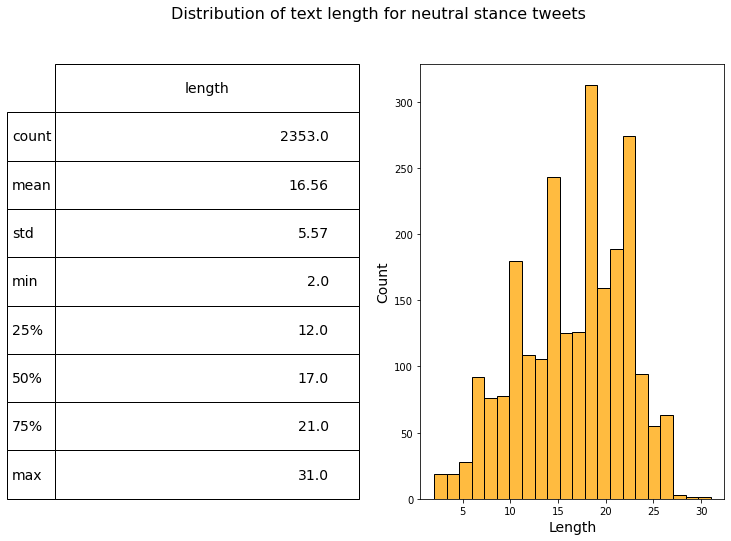

In [10]:
# Plotting the distribution of text length for NONE stance tweets
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(122)
hist = sns.histplot(df_new[df_new['stance']==0]['length'], ax=ax1,color='orange')
hist.set_xlabel("Length", fontsize = 14)
hist.set_ylabel("Count", fontsize = 14)
describe = df_new.length[df_new['stance']==0].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for neutral stance tweets', fontsize=16)

plt.show()

In [11]:
## Count the frequency of words in a dictionary
def count_frequency(dictionary, words):
    for word in words:
        if word not in dictionary.keys():
            dictionary[word] = 1
        else:
            dictionary[word] += 1
    return dictionary

In [12]:
favour_stance = {}
no_stance = {}
against_stance = {}

for i in range(0,len(train_df)):
    tweet = train_df['message'].iloc[i]
    tweet = tweet.lower()
    new  = re.sub('[^A-Za-z0-9]+', ' ', tweet) ## Need to get rid of special characters next
    tokens = nltk.word_tokenize(new) ## word_tokenize does not remove duplicates
  
    ## Preserve the order because calling set does not preserve the order of the words
    ordered_tokens = set()
    result = []
    for word in tokens:
        if word not in ordered_tokens:
            ordered_tokens.add(word)
            result.append(word)
            
    if (train_df['stance'].iloc[i] == 1):
        count_frequency(favour_stance, result) 
    elif (train_df['stance'].iloc[i] == 0):
        count_frequency(no_stance, result) 
    else:
        count_frequency(against_stance, result)

In [13]:
pos = sorted(favour_stance.items(),key=operator.itemgetter(1), reverse=True)
neut = sorted(no_stance.items(),key=operator.itemgetter(1), reverse=True)
neg = sorted(against_stance.items(),key=operator.itemgetter(1), reverse=True)

In [15]:
## Create dataframe from a list of tuples
df_pos = pd.DataFrame(pos, columns = ['word', 'frequency']) 
df_neut = pd.DataFrame(neut, columns = ['word', 'frequency'])
df_neg = pd.DataFrame(neg, columns = ['word', 'frequency'])

print("The number of words in tweets with POSITIVE stance is", len(df_pos))
print("The number of words in tweets with NO stance is", len(df_neut))
print("The number of words in tweets with NEGATIVE stance is", len(df_neg))

The number of words in tweets with POSITIVE stance is 18358
The number of words in tweets with NO stance is 8884
The number of words in tweets with NEGATIVE stance is 13664


In [16]:
# A list of dataframes
frame_list = [df_pos, df_neut, df_neg]
inter_all = frame_list[0]
for df in frame_list[1:]:       
    inter_all = pd.merge(inter_all, df, on='word', how='inner')
inter_all = inter_all.rename(columns = {"frequency_x": "positive stance", 
                                        "frequency_y": "neutral stance",
                                       "frequency": "negative stance"})

print("The number of words appearing in tweets with all of positive, neutral, and negative stance is", 
      len(inter_all))
inter_all.head()

The number of words appearing in tweets with all of positive, neutral, and negative stance is 2836


,word,positive stance,neutral stance,negative stance
0,climate,7180,1393,4030
1,change,7148,1382,3977
2,rt,5763,1083,2817
3,t,4786,984,3842
4,https,4051,836,3781


In [17]:
inter_pos_neutral = pd.merge(df_pos, df_neut, how = 'inner', on = ['word'])
inter_pos_neutral = inter_pos_neutral.rename(columns = {"frequency_x": "positive stance", "frequency_y": "neutral stance"})
print("The size of the overlap b/w words in POSITIVE and NEUTRAL stance tweets is", len(inter_pos_neutral))
inter_pos_neutral.head(10)

The size of the overlap b/w words in POSITIVE and NEUTRAL stance tweets is 3959


,word,positive stance,neutral stance
0,climate,7180,1393
1,change,7148,1382
2,rt,5763,1083
3,t,4786,984
4,https,4051,836
5,co,3630,776
6,the,3630,767
7,to,3609,630
8,is,2519,530
9,a,2354,519


In [18]:
inter_pos_neg = pd.merge(df_pos, df_neg, how = 'inner', on = ['word'])
inter_pos_neg = inter_pos_neg.rename(columns={"frequency_x": "positive stance", "frequency_y": "negative stance"})
print("The size of the overlap b/w words in POSITIVE and NEGATIVE stance tweets is", len(inter_pos_neg))
inter_pos_neg.head(10)

The size of the overlap b/w words in POSITIVE and NEGATIVE stance tweets is 5122


,word,positive stance,negative stance
0,climate,7180,4030
1,change,7148,3977
2,rt,5763,2817
3,t,4786,3842
4,https,4051,3781
5,co,3630,3654
6,the,3630,1576
7,to,3609,1834
8,is,2519,868
9,a,2354,824


In [19]:
inter_neg_neut = pd.merge(df_neg, df_neut, how = 'inner', on = ['word'])
inter_neg_neut = inter_neg_neut.rename(columns={"frequency_x": "negative stance", "frequency_y": "neutral stance"})
print("The size of the overlap b/w words in NEGATIVE and NEUTRAL stance tweets is", len(inter_neg_neut))
inter_neg_neut.head(10)

The size of the overlap b/w words in NEGATIVE and NEUTRAL stance tweets is 3287


,word,negative stance,neutral stance
0,climate,4030,1393
1,change,3977,1382
2,t,3842,984
3,https,3781,836
4,co,3654,776
5,rt,2817,1083
6,to,1834,630
7,the,1576,767
8,trump,1116,171
9,global,1111,1029


In [20]:
## Remove all words from the positive stance dataframe that overlap with the negative stance dataframe 
## and the neutral stance dataframe

df_pos = df_pos.rename(columns={"frequency": "positive stance"})

## Remove duplicates of words with a negative stance
df_inter = inter_pos_neg[['word', 'positive stance']].copy()
print("The number of words overlapping with positive and negative stance is", len(df_inter))
df1 = pd.concat([df_pos, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df1))

df1 = df1.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df1))
print()

## Remove duplicates of words with a neutral stance
df_inter = inter_pos_neutral[['word', 'positive stance']].copy()
print("The number of words overlapping with positive and neutral stance is", len(df_inter))

df2 = pd.concat([df1, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df2))

df2 = df2.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df2))
print()

print("Subtract off the intersection between all three sets.")
df_inter = inter_all[['word', 'positive stance']].copy()
print("The number of words overlapping with positive, neutral, and negative stance is", len(df_inter))

df3 = pd.concat([df2, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df3))

df3 = df3.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df3))

df_pos_unique = df3.copy()
print("\nThe number of words that correspond only to POSITIVE stance are:", len(df_pos_unique))
print("\n The most common words that correspond only to POSITIVE stance are:")
df_pos_unique.head(20)

The number of words overlapping with positive and negative stance is 5122
The length BEFORE dropping duplicates is 23480
The length AFTER dropping duplicates is 13236

The number of words overlapping with positive and neutral stance is 3959
The length BEFORE dropping duplicates is 17195
The length AFTER dropping duplicates is 14949

Subtract off the intersection between all three sets.
The number of words overlapping with positive, neutral, and negative stance is 2836
The length BEFORE dropping duplicates is 17785
The length AFTER dropping duplicates is 12113

The number of words that correspond only to POSITIVE stance are: 12113

 The most common words that correspond only to POSITIVE stance are:


,word,positive stance
64,stephenschlegel,307
65,sjofon,307
239,lkdehj3tnn,73
274,imvotingbecause,62
315,installing,56
368,actonclimate,49
463,bleached,39
488,cracks,37
522,ddlovato,33
523,ivotedbecause,33


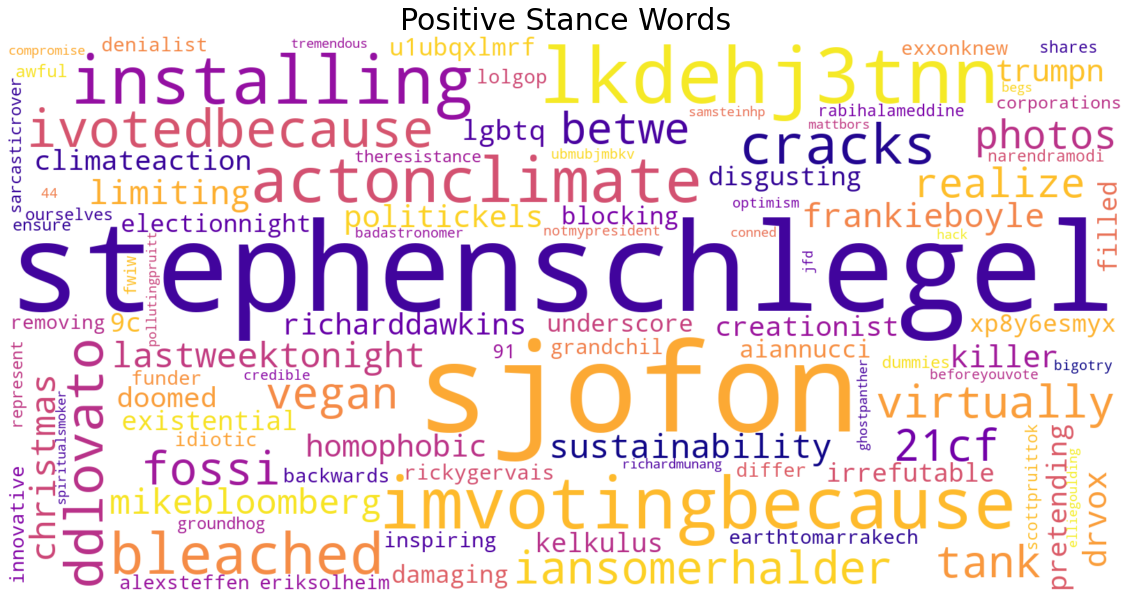

In [21]:
# https://www.datacamp.com/community/tutorials/wordcloud-python 
# https://matplotlib.org/stable/tutorials/colors/colormaps.html

## Make a word cloud of words the correspond to positive stance only
positive_dict = df_pos_unique.set_index('word').T.to_dict('records')

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 100 , width = 1600 , height = 800,
               colormap = "plasma",
               background_color="white").generate_from_frequencies(positive_dict[0])
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.title("Positive Stance Words", fontsize =30)
plt.show()

## Save the word cloud to an image
wc.to_file("positive_sent.png")

In [22]:
## Remove all words from the positive stance dataframe that overlap with the negative stance dataframe
## and neutral stance dataframe

df_neg = df_neg.rename(columns={"frequency": "negative stance"})
print("The number of words with NEGATIVE stance", len(df_neg))

## Remove duplicates of words with a positive stance
df_inter = inter_pos_neg[['word', 'negative stance']].copy()
print("The number of words overlapping with positive and negative stance is", len(df_inter))

df1 = pd.concat([df_neg, df_inter], axis=0)
print("The length BEFORE dropping duplicates is", len(df1))
df1 = df1.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df1))
print()

## Remove duplicates of words with a neutral sentiment
df_inter = inter_neg_neut[['word', 'negative stance']].copy()
print("The number of words overlapping with negative and neutral stance is", len(df_inter))

df2 = pd.concat([df1, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df2))
df2 = df2.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df2))
print()

print("Subtract off the intersection between all three sets.")
df_inter = inter_all[['word', 'negative stance']].copy()
print("The number of words overlapping with positive, neutral, and negative stance is", len(df_inter))

df3 = pd.concat([df2, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df3))

df3 = df3.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df3))

df_neg_unique = df3.copy()
print("\nThe number of words that correspond only to NEGATIVE stance are:", len(df_neg_unique))
print("\nThe most common words that correspond only to NEGATIVE stance are:")
df_neg_unique.head(20)

The number of words with NEGATIVE stance 13664
The number of words overlapping with positive and negative stance is 5122
The length BEFORE dropping duplicates is 18786
The length AFTER dropping duplicates is 8542

The number of words overlapping with negative and neutral stance is 3287
The length BEFORE dropping duplicates is 11829
The length AFTER dropping duplicates is 10927

Subtract off the intersection between all three sets.
The number of words overlapping with positive, neutral, and negative stance is 2836
The length BEFORE dropping duplicates is 13763
The length AFTER dropping duplicates is 8091

The number of words that correspond only to NEGATIVE stance are: 8091

The most common words that correspond only to NEGATIVE stance are:


,word,negative stance
433,alarmists,21
580,cooked,16
581,countermoonbat,16
731,enlist,13
743,whistle,13
744,blower,13
780,ewvqti28t3,12
781,7qv3rfztte,12
790,reviews,12
834,emanuel,11


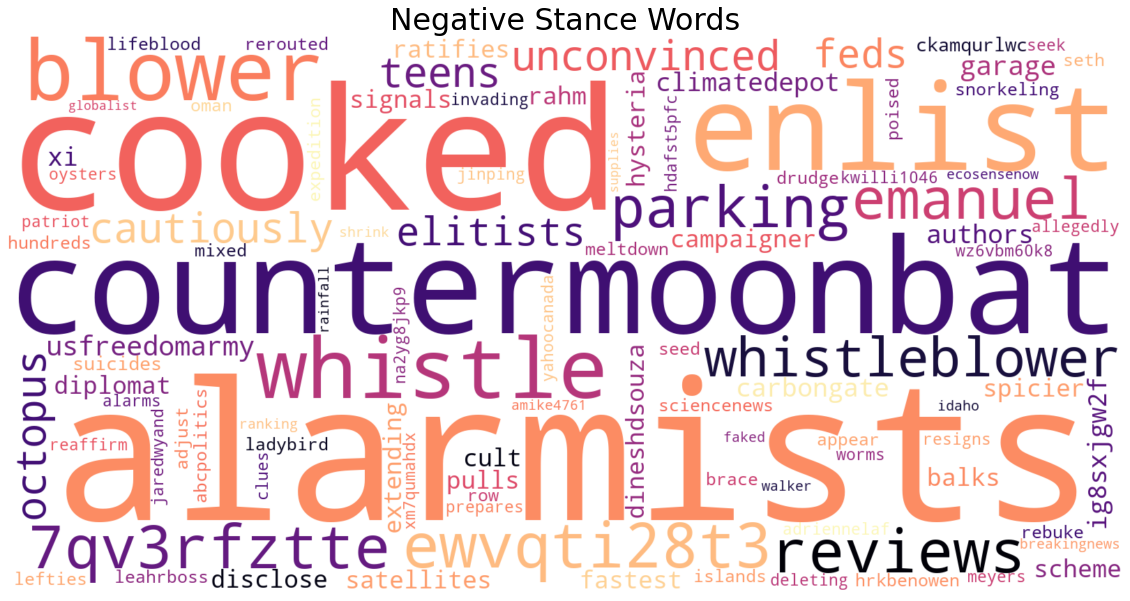

In [23]:
negative_dict = df_neg_unique.set_index('word').T.to_dict('records')

## Make a word cloud of words the correspond to negative stance only
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 100 , width = 1600 , height = 800, 
               background_color="white",
               colormap = "magma").generate_from_frequencies(negative_dict[0])
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.title("Negative Stance Words", fontsize =30)
plt.show()

## Save the word cloud to an image
wc.to_file("negative_sent.png")

In [24]:
# Remove all words from the neutral stance dataframe that overlap with the negative stance dataframe 
# nd positive stance dataframe

df_neut = df_neut.rename(columns={"frequency": "neutral stance"})
print("The number of words with NEUTRAL stance", len(df_neut))

## Remove duplicates of words with a positive stance
df_inter = inter_pos_neutral[['word', 'neutral stance']].copy()
print("The number of words overlapping with positive and neutral stance is", len(df_inter))

df1 = pd.concat([df_neut, df_inter], axis=0)

print("The length BEFORE dropping duplicates is", len(df1))
df1 = df1.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df1))
print()

## Remove duplicates of words with a negative stance
df_inter = inter_neg_neut[['word', 'neutral stance']].copy()
print("The number of words overlapping with negative and neutral stance is", len(df_inter))

df2 = pd.concat([df1, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df2))
df2 = df2.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df2))
print()

print("Subtract off the intersection between all three sets.")
df_inter = inter_all[['word', 'neutral stance']].copy()
print("The number of words overlapping with positive, neutral, and negative stance is", len(df_inter))

df3 = pd.concat([df2, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df3))

df3 = df3.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df3))

df_neutral_unique = df3.copy()
print("\nThe number of words that correspond only to NEUTRAL stance are:", len(df_neutral_unique))
print("\nThe most common words that correspond only to NEUTRAL stance are:")
df_neutral_unique.head(20)

The number of words with NEUTRAL stance 8884
The number of words overlapping with positive and neutral stance is 3959
The length BEFORE dropping duplicates is 12843
The length AFTER dropping duplicates is 4925

The number of words overlapping with negative and neutral stance is 3287
The length BEFORE dropping duplicates is 8212
The length AFTER dropping duplicates is 7310

Subtract off the intersection between all three sets.
The number of words overlapping with positive, neutral, and negative stance is 2836
The length BEFORE dropping duplicates is 10146
The length AFTER dropping duplicates is 4474

The number of words that correspond only to NEUTRAL stance are: 4474

The most common words that correspond only to NEUTRAL stance are:


,word,neutral stance
186,interviewer,21
202,ultravlolence,20
206,civiljustus,20
207,hypyswhvvv,20
428,zimmer,10
429,8zyozk4kfr,10
493,jedrlee,8
718,kentut,6
719,penyebab,6
720,utama,6


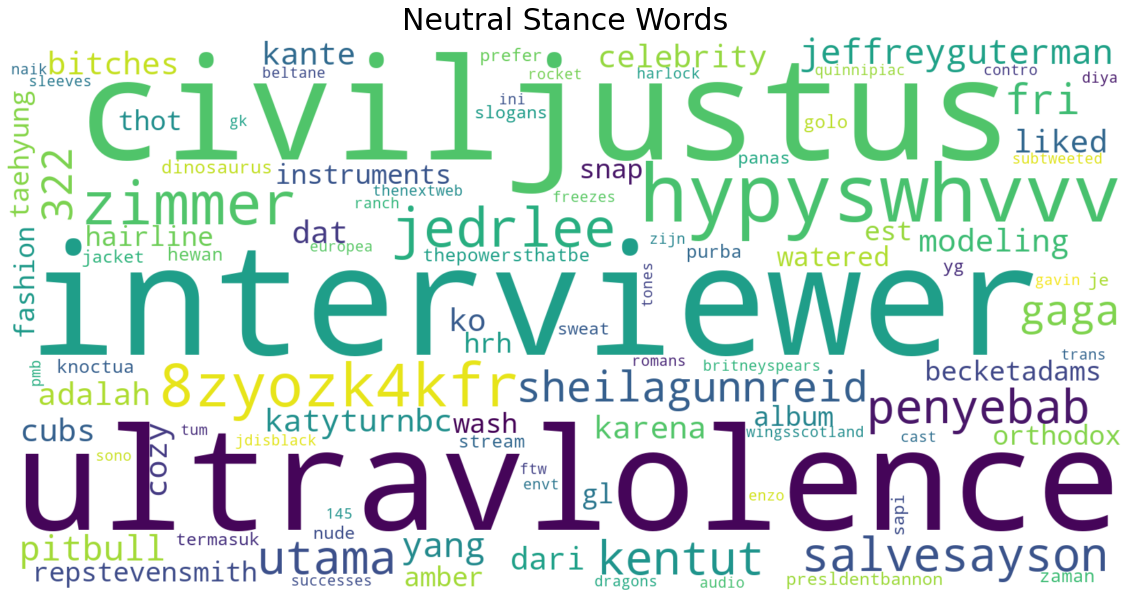

In [25]:
neutral_dict = df_neutral_unique.set_index('word').T.to_dict('records')

## Make a word cloud of words the correspond to neutral stance only
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 100 , width = 1600 , height = 800,
               background_color="white").generate_from_frequencies(neutral_dict[0])
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.title("Neutral Stance Words", fontsize =30)
plt.show()

## Save the word cloud to an image
wc.to_file("neutral_sent.png")